### VdP Iterative resolution

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import os

def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=1000):

    # Initial value of z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # Calculate y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # Calculate z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        # Handle potential division by zero or very small denominator
        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan, iterations
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan, iterations

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            # Convergence achieved
            R_s = 1 / z_curr
            return R_s, iterations+1

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan, max_iterations

### Data with no T fluctuation

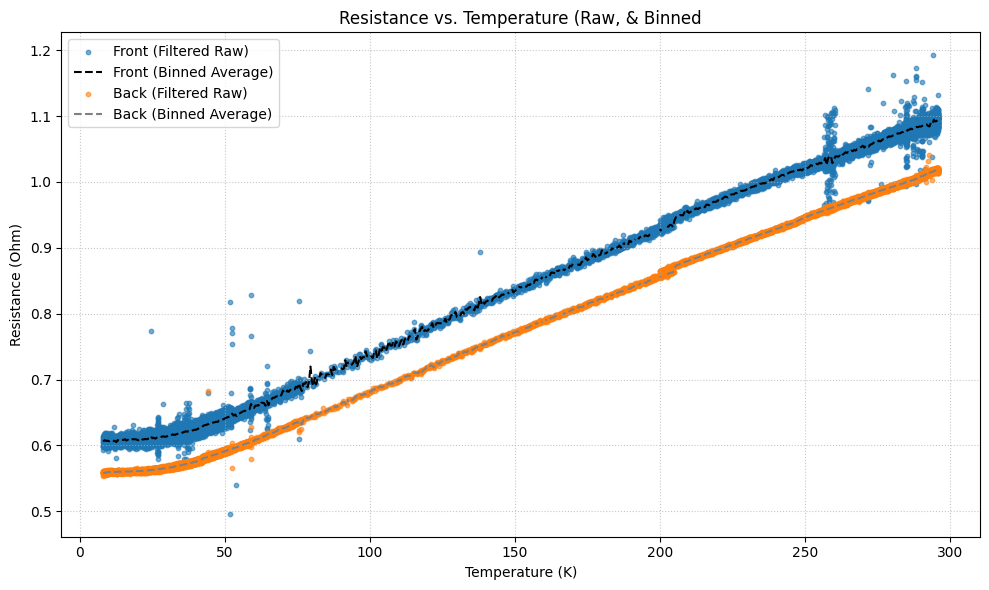

In [34]:
file_path = "DataSets/heating_8_to_296.dat"

# Load the data using pandas.
# sep='\s+' handles one or more spaces as delimiters.
# header=None indicates no header row.
# skipinitialspace=True handles potential leading spaces.
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)

# The last row in your data might be incomplete. Remove any rows with NaN values if they appear.
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)


# # ---------------------------------------------
# # Create mask for filtering
sel_mask = (
    (front_temp_raw > 8) & (back_temp_raw > 8) &
    (front_temp_fluct_raw == 0) & (back_temp_fluct_raw == 0)
)

# # Apply mask
Tf = front_temp_raw[sel_mask].values
Rf = front_R[sel_mask].values
Tb = back_temp_raw[sel_mask].values
Rb = back_R[sel_mask].values


# # ---------------------------------------------
sample_T = np.arange(8.0, 296.5, 0.5) # Equivalent to 8:0.5:296
Ns = len(sample_T)
clean_Rf = np.zeros(Ns)
clean_Rb = np.zeros(Ns)

jf = 0 
jb = 0

for i in range(Ns):
    lim = sample_T[i] + 0.25

    # Process Front data
    count_f = 0
    sum_rf = 0.0
    while jf < len(Rf) and Tf[jf] < lim:
        sum_rf += Rf[jf]
        count_f += 1
        jf += 1
    
    if count_f > 0:
        clean_Rf[i] = sum_rf / count_f
    else:
        clean_Rf[i] = np.nan # Assign 0 if no data points fall into the bin

    # Process Back data
    count_b = 0
    sum_rb = 0.0
    while jb < len(Rb) and Tb[jb] < lim:
        sum_rb += Rb[jb]
        count_b += 1
        jb += 1
    
    if count_b > 0:
        clean_Rb[i] = sum_rb / count_b
    else:
        clean_Rb[i] = np.nan # Assign NaN if no data points fall into the bin

# # ---------------------------------------------

# Plot 1: Raw, Cleaned, and Interp Resistance vs. Temperature
plt.figure(figsize=(10, 6))
plt.scatter(Tf, Rf, s=10, label="Front (Filtered Raw)", alpha=0.6)
plt.plot(sample_T, clean_Rf, linestyle='--', color='black', label="Front (Binned Average)")
plt.scatter(Tb, Rb, s=10, label="Back (Filtered Raw)", alpha=0.6)
plt.plot(sample_T, clean_Rb, linestyle='--', color='gray', label="Back (Binned Average)")
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Raw, & Binned")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature (VdP Method)')

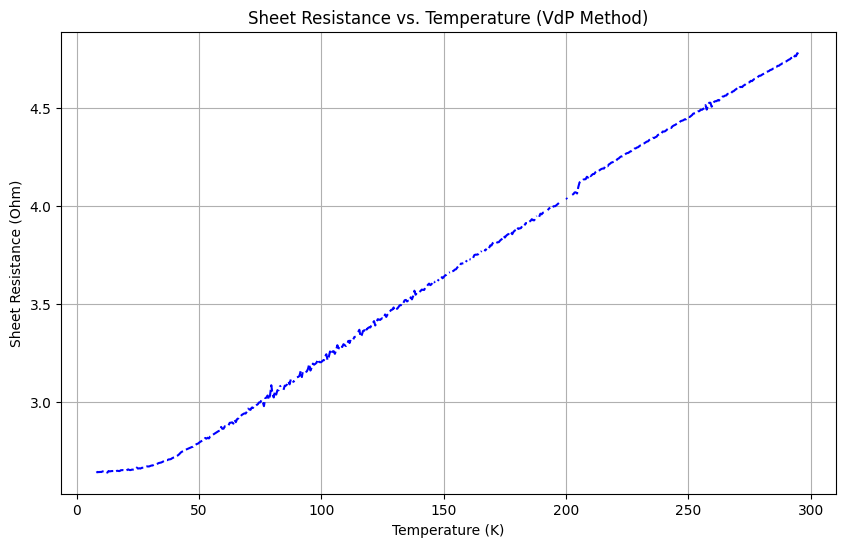

In [35]:
clean_Rs = np.zeros(Ns)
i = 0
while i < Ns:
    clean_Rs[i] = calculate_sheet_resistance_vdp(clean_Rf[i], clean_Rb[i])[0]
    i += 1  

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(sample_T, clean_Rs, linestyle='--', color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature (VdP Method)")

### Data with $\Delta T < 30mK$ 

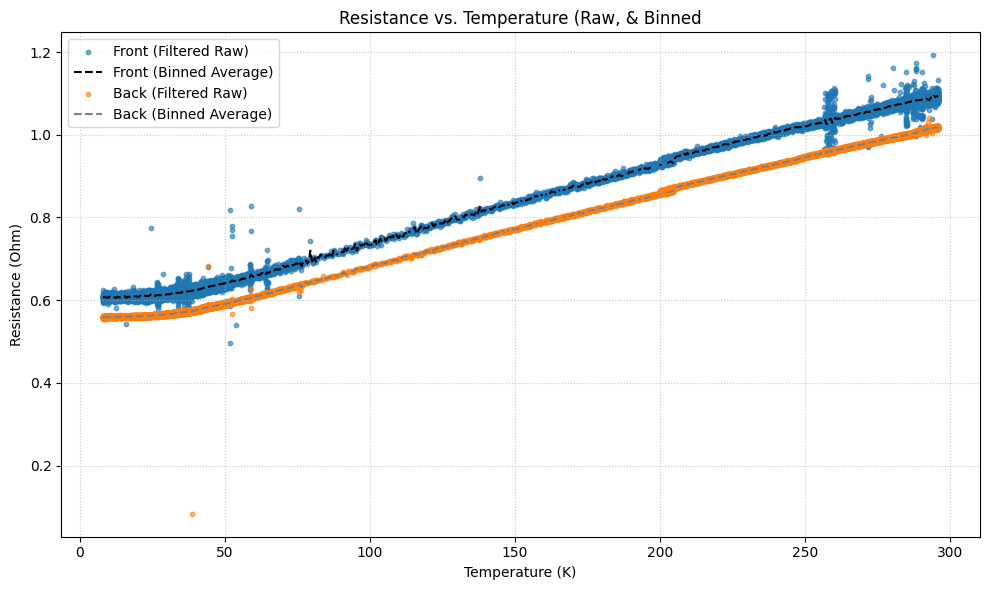

In [ ]:
file_path = "DataSets/heating_8_to_296.dat"

# Load the data using pandas.
# sep='\s+' handles one or more spaces as delimiters.
# header=None indicates no header row.
# skipinitialspace=True handles potential leading spaces.
df = pd.read_csv(file_path, sep=r'\s+', header=None, skipinitialspace=True)

# The last row in your data might be incomplete. Remove any rows with NaN values if they appear.
df = df.dropna()

# front_temp (Column 6 -> index 5)
# front_temp_fluct (Column 7 -> index 6)
# front_R (Column 8 -> index 7)
# back_temp (Column 17 -> index 16)
# back_temp_fluct (Column 18 -> index 17)
# back_R (Column 19 -> index 18)

front_temp_raw = df.iloc[:, 5].astype(float)
front_temp_fluct_raw = df.iloc[:, 6].astype(float)
front_R = df.iloc[:, 7].astype(float)

back_temp_raw = df.iloc[:, 16].astype(float)
back_temp_fluct_raw = df.iloc[:, 17].astype(float)
back_R = df.iloc[:, 18].astype(float)


# # ---------------------------------------------
cutoff = 30e-3 # 30 mK

# # Create mask for filtering
sel_mask = (
    (front_temp_raw > 8) & (back_temp_raw > 8) &
    (front_temp_fluct_raw < cutoff) & (back_temp_fluct_raw <= cutoff)
)

# # Apply mask
Tf = front_temp_raw[sel_mask].values
Rf = front_R[sel_mask].values
Tb = back_temp_raw[sel_mask].values
Rb = back_R[sel_mask].values


# # ---------------------------------------------
sample_T = np.arange(8.0, 296.5, 0.5) # Equivalent to 8:0.5:296
Ns = len(sample_T)
clean_Rf = np.zeros(Ns)
clean_Rb = np.zeros(Ns)

jf = 0 
jb = 0

for i in range(Ns):
    lim = sample_T[i] + 0.25

    # Process Front data
    count_f = 0
    sum_rf = 0.0
    while jf < len(Rf) and Tf[jf] < lim:
        sum_rf += Rf[jf]
        count_f += 1
        jf += 1
    
    if count_f > 0:
        clean_Rf[i] = sum_rf / count_f
    else:
        clean_Rf[i] = np.nan # Assign 0 if no data points fall into the bin

    # Process Back data
    count_b = 0
    sum_rb = 0.0
    while jb < len(Rb) and Tb[jb] < lim:
        sum_rb += Rb[jb]
        count_b += 1
        jb += 1
    
    if count_b > 0:
        clean_Rb[i] = sum_rb / count_b
    else:
        clean_Rb[i] = np.nan # Assign NaN if no data points fall into the bin

# # ---------------------------------------------

# Plot 1: Raw, Cleaned, and Interp Resistance vs. Temperature
plt.figure(figsize=(10, 6))
plt.scatter(Tf, Rf, s=10, label="Front (Filtered Raw)", alpha=0.6)
plt.plot(sample_T, clean_Rf, linestyle='--', color='black', label="Front (Binned Average)")
plt.scatter(Tb, Rb, s=10, label="Back (Filtered Raw)", alpha=0.6)
plt.plot(sample_T, clean_Rb, linestyle='--', color='gray', label="Back (Binned Average)")
plt.xlabel("Temperature (K)")
plt.ylabel("Resistance (Ohm)")
plt.title("Resistance vs. Temperature (Raw, & Binned")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Sheet Resistance vs. Temperature (VdP Method)')

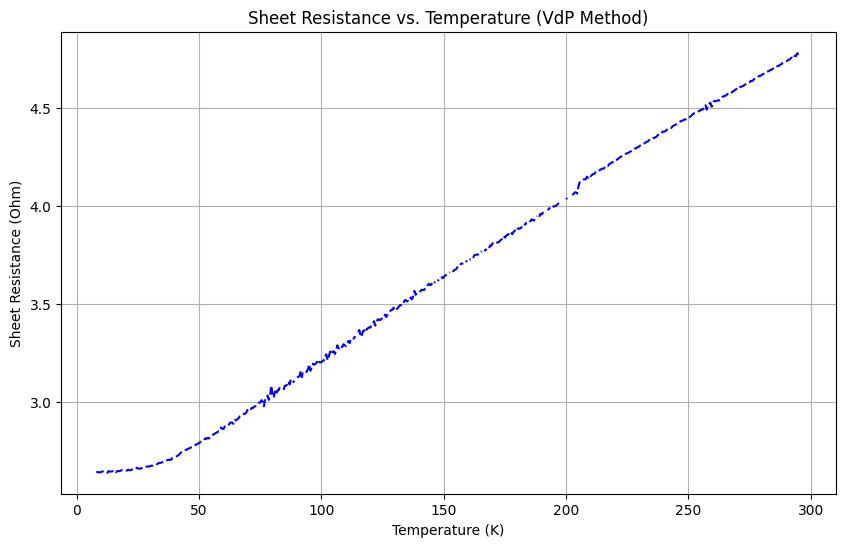

In [37]:
clean_Rs = np.zeros(Ns)
i = 0
while i < Ns:
    clean_Rs[i] = calculate_sheet_resistance_vdp(clean_Rf[i], clean_Rb[i])[0]
    i += 1  

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(sample_T, clean_Rs, linestyle='--', color='blue', label='Sheet Resistance (VdP)')
plt.xlabel("Temperature (K)")
plt.ylabel("Sheet Resistance (Ohm)")
plt.title("Sheet Resistance vs. Temperature (VdP Method)")